## Training Binding Energy Models for -O and -OH

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ase
from ase.db import connect
import sys
import os

sys.path.append('../scripts')
from Slab import expand_triangle, Slab, inside_triangle
from FeatureReader import OntopStandard111, FccStandard111
from ase.db import connect
from ase.visualize import view

In [3]:
db_folder = "../DFT_data/"
features_folder = "../csv_features/"

## Setting reference energies

### Reaction 4: O adsorption

The chemical reaction:
$$ H_2O (l) + * \rightleftharpoons ^*O + 2(H^+ + e^-) $$

The equation for the binding energy:
$$ \Delta E = E_{^*O} - E_{H_2O (g)} - E_{*} + E_{H_2} -2eU $$
This includes the contribution from the potential, which we'll take care for later. Hence, we'll have the model predict just the non-voltage-dependant part:
$$ \Delta E = E_{^*O} - E_{H_2O (g)} - E_{*} + E_{H_2} $$

### Reaction 5: OH adsorption

The chemical reaction:
$$ H_2O (l) + * \rightleftharpoons ^*OH + (H^+ + e^-) $$

The equation for the binding energy:
$$ \Delta E = E_{^*OH} - E_{H_2O (g)} - E_{*} + \frac{1}{2} E_{H_2} -eU $$
This includes the contribution from the potential, which we'll take care for later. Hence, we'll have the model predict just the non-voltage-dependant part:
$$ \Delta E = E_{^*OH} - E_{H_2O (g)} - E_{*} + \frac{1}{2} E_{H_2} $$

In [4]:
# Free (eV)
CO2   = {"ZPE": 0.31, "CpdT": 0.10, "minusTS": -0.66, "TS": 0.66}
CO    = {"ZPE": 0.13, "CpdT": 0.09, "minusTS": -0.61, "TS": 0.61}
H2    = {"ZPE": 0.28, "CpdT": 0.09, "minusTS": -0.40, "TS": 0.40}
H2O   = {"ZPE": 0.57, "CpdT": 0.10, "minusTS": -0.67, "TS": 0.67}
HCOOH = {"ZPE": 0.90, "CpdT": 0.11, "minusTS": -0.99, "TS": 0.99}
#Slab = {"ZPE": 0.00, "CpdT": 0.00, "minusTS": -0.00} #Holy moly, den her overskrev Slab funktionen

# *Bound to the surface (eV)
# Bidentate *OOCH?
bound_CO   = {"ZPE": 0.19, "CpdT": 0.08, "minusTS": -0.16, "TS": 0.16}
bound_OH   = {"ZPE": 0.36, "CpdT": 0.05, "minusTS": -0.08, "TS": 0.08}
bound_OCHO = {"ZPE": 0.62, "CpdT": 0.11, "minusTS": -0.24, "TS": 0.24} #Either bidentate or monodentate. Use for both for now
bound_O    = {"ZPE": 0.07, "CpdT": 0.03, "minusTS": -0.04, "TS": 0.04}
bound_COOH = {"ZPE": 0.62, "CpdT": 0.10, "minusTS": -0.19, "TS": 0.19}
bound_H    = {"ZPE": 0.23, "CpdT": 0.01, "minusTS": -0.01, "TS": 0.01}

# Approximation Factors (FA)
AF = {"CO2": CO2, "CO": CO, "H2": H2, "H2O": H2O, "HCOOH": HCOOH, \
      "bound_CO": bound_CO, "bound_OH": bound_OH, "bound_OCHO": bound_OCHO, \
      "bound_O": bound_O, "bound_COOH": bound_COOH, "bound_H": bound_H, \
      "Slab": Slab}

# This is from the molecules_out.db file
molecules_dict = {'CO': -12.848598765234707,\
 'CO2': -19.15168636258064,\
 'CH2O2': -25.7548327798152,\
 'C2H4O2': -41.95993780269195,\
 'H2': -6.67878491734772,\
 'H2O': -12.225511685485456,\
 'CH2O': -19.92286258910958,\
 'CH4O': -27.652189372849637,\
 'C2H6O': -43.67355392866396,\
 'C2H2O2': -32.92328015484662,\
 'C2H2O4': -44.117581976029946}

## O features

In [150]:
### Summing up all the Approximation Factors for O
ZpE_sum  = AF["bound_O"]["ZPE"]  - AF["H2O"]["ZPE"]  + AF["H2"]["ZPE"]
CpdT_sum = AF["bound_O"]["CpdT"] - AF["H2O"]["CpdT"] + AF["H2"]["CpdT"]
TS_sum   = AF["bound_O"]["TS"]   - AF["H2O"]["TS"]   + AF["H2"]["TS"]
correction_constant_O = ZpE_sum + CpdT_sum - TS_sum
# Add extra correction constant here
# 

In [131]:
def correct_DFT_energy_O(correction_constant, molecules_dict, E_O, E_slab):
    DeltaE = E_O - molecules_dict["H2O"] + molecules_dict["H2"] - E_slab
    DeltaG = DeltaE + correction_constant
    return DeltaG

## OH features

In [132]:
### Summing up all the Approximation Factors for OH
ZpE_sum  = AF["bound_OH"]["ZPE"]  - AF["H2O"]["ZPE"]  + 1/2*AF["H2"]["ZPE"]
CpdT_sum = AF["bound_OH"]["CpdT"] - AF["H2O"]["CpdT"] + 1/2*AF["H2"]["CpdT"]
TS_sum   = AF["bound_OH"]["TS"]   - AF["H2O"]["TS"]   + 1/2*AF["H2"]["TS"]
correction_constant_OH = ZpE_sum + CpdT_sum - TS_sum

In [133]:
def correct_DFT_energy_OH(correction_constant, molecules_dict, E_OH, E_slab):
    DeltaE = E_OH - molecules_dict["H2O"] + 1/2*molecules_dict["H2"] - E_slab
    DeltaG = DeltaE + correction_constant
    return DeltaG

### Make the feature vectors and save .csv files

In [134]:
# Specify metals
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
alloy = ''.join(metals)

# Specify name of databases
db_name_O = 'O_out.db'
db_name_OH = 'OH_out.db'
db_name_slab = "slabs_out_OH_O.db"

# Initiate feature readers
reader_O = FccStandard111(metals)
reader_OH = OntopStandard111(metals)

site_ids_O = [16, 17, 18]

# Initiate counters of rejected samples
rejected_O = 0
rejected_OH = 0

# Writer headers to files
with open(f'{features_folder}O_features.csv', 'w') as file_O:
    column_names = [f"feature{n}" for n in range(55)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_O}row')
    file_O.write(",".join(column_names))
    
# Writer headers to files
with open(f'{features_folder}OH_features.csv', 'w') as file_OH:
    column_names = [f"feature{n}" for n in range(20)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_O}row')
    file_OH.write(",".join(column_names))
    
# Load HEA(111) databases
with connect(f'{db_folder}{db_name_O}') as db_O,\
     connect(f'{db_folder}{db_name_OH}') as db_OH,\
     connect(f'{db_folder}{db_name_slab}') as db_slab,\
     open(f'{features_folder}O_features.csv', 'a') as file_O,\
     open(f'{features_folder}OH_features.csv', 'a') as file_OH:
    #print("A1")
    # Iterate through slabs without adsorbates
    for row_slab in db_slab.select('energy', H=0, C=0, O=0): # This doesn't even trigger lmao
        #print("A2")
        # Iterate through the two adsorbates
        for ads in ['OH', 'O']:
            #print("A3")
            # Set adsorbate-specific parameters
            if ads == 'OH':
                db = db_OH
                kw = {'O': 1, 'H': 1}
                db_name = db_name_OH
                out_file = file_OH

            elif ads == 'O':
                db = db_O
                kw = {'O': 1, 'H': 0}
                db_name = db_name_O
                out_file = file_O

            # Set counter of matched slabs between the databases to zero
            n_matched = 0

            # Get the corresponding slab with adsorbate
            for row in db.select('energy', **kw, **row_slab.count_atoms()):
                #print("A4")
                # If symbols match up
                if row.symbols[:-len(ads)] == row_slab.symbols:
                    #print("A5")
                    # Increment the counter of matched structures
                    n_matched += 1

                    # Get atoms object
                    atoms = db.get_atoms(row.id)

                    # Make slab instance
                    slab = Slab(atoms, ads=ads, ads_atom='O')

                    # If the adsorbate is *OH
                    if ads == 'OH':

                        # Get adsorption site elements as neighbors within a radius
                        site_elems, site = slab.get_adsorption_site(radius=2.6, hollow_radius=2.6)

                        # If the site does not consist of exactly one atom, then skip this sample
                        # as the *OH has moved too far away from an on-top site
                        try:
                            if len(site_elems) !=1:
                                rejected_OH += 1
                                #slab.view()
                                continue
                        except TypeError:
                            print(site_elems, site)
                            print(row_slab.id, row.id)
                            slab.view()
                            exit()

                        # Get features of structure
                        features = reader_OH.get_features(slab, radius=2.6)
                        
                        ### This part is now adsorbate-specific ###
                        # Get adsorption energy
                        E_ads = correct_DFT_energy_OH(correction_constant_OH, molecules_dict, row.energy, row_slab.energy) # This is the new formula

                        # Write output to file
                        features = ','.join(map(str, features))
                        out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

                    # Else, if the adsorbate is O*
                    elif ads == 'O':

                        # Get hollow site planar corner coordinates
                        site_atoms_pos_orig = atoms.positions[site_ids_O, :2]

                        # Get expanded triangle vertices
                        site_atoms_pos = expand_triangle(site_atoms_pos_orig, expansion=1.45)

                        # Get position of adsorbate atom (with atom index XXX 20 XXX)
                        ads_pos = atoms.positions[20][:2]

                        # If the oxygen is outside the expanded fcc triangle,
                        # then it is most likely in an hcp site, that is not
                        # being modeled
                        if not inside_triangle(ads_pos, site_atoms_pos):
                            rejected_O += 1
                            continue

                        # Get features of structure
                        features = reader_O.get_features(slab, radius=2.6, site_ids=site_ids_O)

                        ### This part is now adsorbate-specific ###
                        # Get adsorption energy
                        E_ads = correct_DFT_energy_O(correction_constant_O, molecules_dict, row.energy, row_slab.energy) # This is the new formula

                        # Write output to file
                        features = ','.join(map(str, features))
                        out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

            # Print a message if more than one slabs were matched. This probably means that
            # the same slab has accidentally been saved multiple to the database
            if n_matched > 1:
                print(f'[INFO] {n_matched} {ads} and slab matched for row {row_slab.id} in {db_name_slab}')

            # Print a message if no slabs were matched. This probably means that the DFT calculation
            # did not converge and was left out
            #elif n_matched == 0:
                #print(f'[INFO] No match found in {db_name} for row {row_slab.id} in {db_name_slab}')

# Print the number of rejected samples to screen
print('rejected OH samples: ', rejected_OH)
print('rejected O samples: ', rejected_O)

rejected OH samples:  20
rejected O samples:  1


## Train binding energy models for OH and O

In [135]:
import warnings
warnings.filterwarnings('ignore')

import xgboost;
from xgboost import XGBRegressor;
import pandas as pd;
from sklearn.model_selection import train_test_split;
from xgboost import plot_importance;
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
import matplotlib.ticker as ticker

import random
random.seed(1)
np.random.seed(1)

import time

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
import matplotlib.ticker as ticker

figure_folder = "../figures/DeltaG_models/"

In [136]:
def learning_curve(model_name): #For regressor
    # retrieve performance metrics
    results = model_name.evals_result()
    epochs = len(results['validation_0']['mae'])
    x_axis = range(0, epochs)
    
    # plot log loss
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax.plot(x_axis, results['validation_1']['mae'], label='Validation')
    ax.legend()
    
    plt.xlabel("Epoch")
    plt.ylabel('Log Loss')
    plt.title('XGBoost Loss curve')
    plt.show()
    return None

def single_parity_plot(model_name, X_test, y_test_series, training_data, adsorbate):
    model_predictions = model_name.predict(X_test)
    
    model_type_title = "Gradient Boosting"
    #Fix sklearn LinearRegressions weird list of lists thing
    if len(np.shape(model_predictions)) == 2:
        #print("For søren, jeg har fået en LinearRegression model fra sklearn. Sikke skørt det er at returnere predictions som en liste af en liste. Det vil jeg straks rette op på")
        #print("model_predictions: ", model_predictions)
        model_predictions = model_predictions.reshape(-1)
        #print("model_predictions after reshaping: ", model_predictions)
        
        #Sørg for at den skriver linear regression model i titlen
        model_type_title = "Linear Regression"
    
    y_test = y_test_series.values.tolist()
    
    # Find MAE:
    errors = y_test_series.to_numpy().reshape(-1)-model_predictions
    MAE = np.mean(np.abs(errors))
    #print(f"MAE: {MAE:.3f}")

    if adsorbate == "H and O":
        #I want two plt.scatter, one for each adsorbate
        flat_list = [item for sublist in X_test[["adsorbate"]].values.tolist() for item in sublist]
        pred_H = [model_predictions[n] for n in range(len(y_test)) if flat_list[n] == 0]
        pred_O = [model_predictions[n] for n in range(len(y_test)) if flat_list[n] == 1]
        true_H = [y_test[n] for n in range(len(y_test)) if flat_list[n] == 0]
        true_O = [y_test[n] for n in range(len(y_test)) if flat_list[n] == 1]
        
        MAE_O = np.mean(np.abs(np.array(true_O).reshape(-1)-pred_O))
        MAE_H = np.mean(np.abs(np.array(true_H).reshape(-1)-pred_H))
        print(f"MAE(O): {MAE_O:.3f}")
        print(f"MAE(H): {MAE_H:.3f}")
    
    fig, ax1 = plt.subplots()
    
    if adsorbate == "H and O":
        ax1.scatter(true_H, pred_H, s = 20, c = "tab:green", label = "Adsorbate: H", marker = "$H$")
        ax1.scatter(true_O, pred_O, s = 20, c = "tab:red", label = "Adsorbate: O", marker = "$O$")
        
        ax1.set_title(model_type_title + " model predictions of $\Delta G_{*O}^{DFT} (eV)$ and $\Delta G_{*H}^{DFT} (eV)$ \n Training data: " + training_data)
    
    if adsorbate == "O":
        ax1.scatter(y_test_series, model_predictions, s = 20, c = "tab:red", label = "Adsorbate: O", marker = "$O$")
        ax1.set_title(model_type_title + " model predictions of $\Delta G_{*O}^{DFT} (eV)$ \n Training data: " + training_data)
        
    if adsorbate == "OH":
        ax1.scatter(y_test_series, model_predictions, s = 60, c = "tab:blue", label = "Adsorbate: OH", marker = "$OH$")
        ax1.set_title(model_type_title + " model predictions of $\Delta G_{*OH}^{DFT} (eV)$")
    
    if adsorbate == "H":
        ax1.scatter(y_test_series, model_predictions, s = 20, c = "tab:green", label = "Adsorbate: H", marker = "$H$")
        ax1.set_title(model_type_title + " model predictions of $\Delta G_{*H}^{DFT} (eV)$")

    if adsorbate == "COOH":
        ax1.scatter(y_test_series, model_predictions, s = 20, c = "cornflowerblue", label = "Adsorbate: COOH", marker = "x")
        ax1.set_title(model_type_title + " model predictions of $\Delta G_{*COOH}^{DFT} (eV)$")
    
    if adsorbate == "COOH+H":
        ax1.scatter(y_test_series, model_predictions, s = 20, c = "seagreen", label = "Adsorbate: COOH+H", marker = "x")
        ax1.set_title(model_type_title + " model predictions of $\Delta G_{*COOH+*H}^{DFT} (eV)$")

    
    if adsorbate == "CO":
        ax1.scatter(y_test_series, model_predictions, s = 60, c = "orangered", label = "Adsorbate: CO", marker = "$CO$")
        ax1.set_title(model_type_title + " model predictions of $\Delta G_{*CO}^{DFT} (eV)$")
    
    ax1.set_xlabel("$\Delta G_{*Adsorbate}^{DFT} (eV)$")
    ax1.set_ylabel("$\Delta G_{*Adsorbate}^{Pred} (eV)$")
    
    ax1.text(0.8, 2.4, f"MAE(test) = {MAE:.3f}", color="deepskyblue", fontweight='bold', fontsize = 12)
    
    left, bottom, width, height = [0.16, 0.65, 0.2, 0.2]
    ax_inset = fig.add_axes([left, bottom, width, height])
    
    pm, lw, fontsize = 0.1, 0.5, 14

    ax_inset.hist(errors, bins=np.arange(-0.6, 0.6, 0.05),
          color="deepskyblue",
          density=True,
          alpha=0.7,
          histtype='stepfilled',
          ec='black',
          lw=lw)
    
    # Make plus/minus 0.1 eV lines in inset axis
    ax_inset.axvline(pm, color='black', ls='--', dashes=(5, 5), lw=lw)
    ax_inset.axvline(-pm, color='black', ls='--', dashes=(5, 5), lw=lw)
    
    # Set x-tick label fontsize in inset axis
    ax_inset.tick_params(axis='x', which='major', labelsize=fontsize-6)
    
    # Remove y-ticks in inset axis
    ax_inset.tick_params(axis='y', which='major', left=False, labelleft=False)
    
    # Set x-tick locations in inset axis
    ax_inset.xaxis.set_major_locator(ticker.MultipleLocator(0.50))
    ax_inset.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    
    # Remove the all but the bottom spines of the inset axis
    for side in ['top', 'right', 'left']:
        ax_inset.spines[side].set_visible(False)
    
    # Make the background transparent in the inset axis
    ax_inset.patch.set_alpha(0.0)
    
    # Print 'pred-calc' below inset axis
    ax_inset.text(0.5, -0.33,
                  '$pred - DFT$ (eV)',
                  ha='center',
                  transform=ax_inset.transAxes,
                  fontsize=fontsize-7)
    
    # Make central and plus/minus 0.1 eV lines in scatter plot
    lims = [-0.3, 2.75]
    
    # Set x and y limits
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)
    
    ax1.plot(lims, lims,
            lw=lw, color='black', zorder=1,
            label=r'$\rm \Delta G_{pred} = \Delta G_{DFT}$')
    
    # Make plus/minus 0.1 eV lines around y = x
    ax1.plot(lims, [lims[0]+pm, lims[1]+pm],
            lw=lw, ls='--', dashes=(5, 5), color='black', zorder=1,
            label=r'$\rm \pm$ {:.1f} eV'.format(pm))
            
    ax1.plot([lims[0], lims[1]], [lims[0]-pm, lims[1]-pm],
            lw=lw, ls='--', dashes=(5, 5), color='black', zorder=1)
    
    ax1.legend(frameon=False,
          bbox_to_anchor=[0.45, 0.0],
          loc='lower left',
          handletextpad=0.2,
          handlelength=1.0,
          labelspacing=0.2,
          borderaxespad=0.1,
          markerscale=1.5,
          fontsize=fontsize-5)
    
    #plt.savefig(figure_folder + "Parity_trained_OH_tested_BOTH.png", dpi = 300, bbox_inches = "tight")
    # Save figure with a random name, rename later
    plt.savefig(figure_folder + str(time.time())[6:10]+str(time.time())[11:15], dpi = 300, bbox_inches = "tight")
    plt.show()
    return None

def prepare_csv(feature_folder, filename, adsorbate):
    init_df = pd.read_csv(feature_folder + filename)

    # Add a first column about the adsorbate
    adsorbate_df = pd.DataFrame([adsorbate for x in range(len(init_df))], columns = ["adsorbate"])

    #Combine
    prepared_df = pd.concat([adsorbate_df, init_df], axis = 1)
    return prepared_df

def return_mae(model_name, X_test, y_test_series): #Returns MAE on test set for a model (Either XGBoost or )
    model_predictions = model_name.predict(X_test)
    
    if len(np.shape(model_predictions)) == 2:
        model_predictions = model_predictions.reshape(-1)
    y_test = y_test_series.values.tolist()
    
    # Find MAE:
    errors = y_test_series.to_numpy().reshape(-1)-model_predictions
    MAE = np.mean(np.abs(errors))
    return MAE

### Load OH data

In [137]:
# H = 0
# O = 1  #NO LONGER USED
# OH = 2 #NO LONGER USED
# COOH = 3
# CO = 4

In [138]:
feature_folder = "../csv_features/"
filename = "OH_features.csv"
# Let's import O and H first. Add an initial row that says "I'm an O" or "I'm an H". The hollow model will take care of seperating them. But the data might share patterns that the model can use, even though the adsorbate is different.

# WHY AM I STILL USING THE INITIAL ROW?? I'M NOT COMBINING MODELS ANYMORE, AND I HAVEN'T. Should I abort and train all the models again? Or just keep using them?
# I'll just keep on using the goddamn initial thingies

#OH_df = prepare_csv(feature_folder, , 2) #H kalder vi 0
OH_df = pd.read_csv(feature_folder + filename)
full_df = pd.concat([OH_df], axis = 0)
all_cols = full_df.columns
#Seperate the energies and remove the useless columns

X = full_df.loc[:, :all_cols[-4]]
y = full_df[["G_ads (eV)"]]

(array([15., 42., 61., 56., 55., 46., 46., 34., 17.,  3.]),
 array([0.914131 , 1.0511171, 1.1881032, 1.3250893, 1.4620754, 1.5990615,
        1.7360476, 1.8730337, 2.0100198, 2.1470059, 2.283992 ]),
 <BarContainer object of 10 artists>)

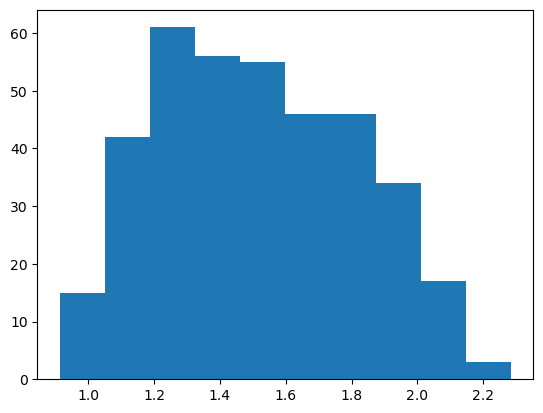

In [139]:
plt.hist(y)

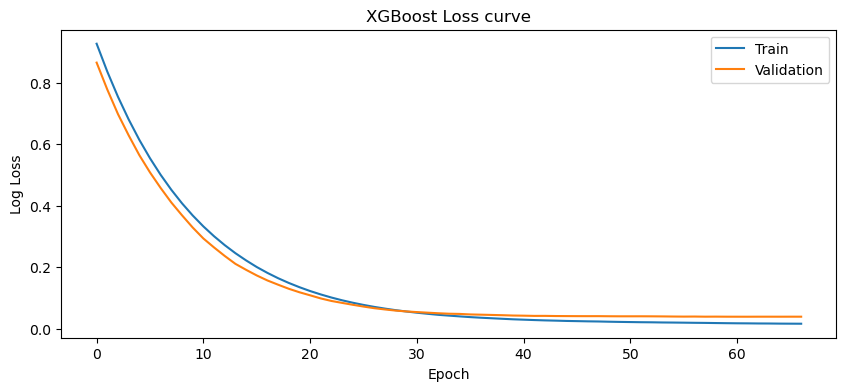

Training score:  0.9938972132827701
Validation score:  0.9636342883626006


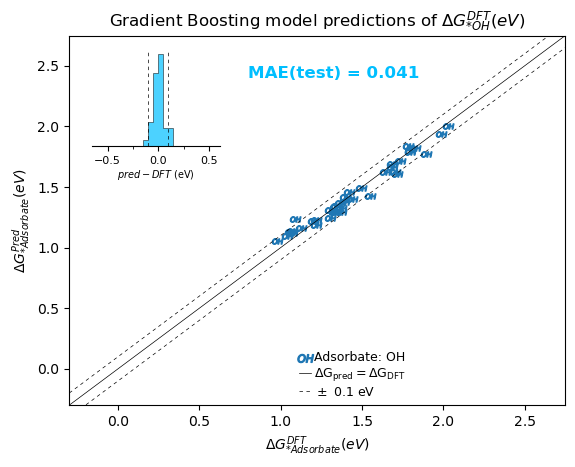

In [140]:
# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_OH =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_OH.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Save model in the /models folder
XGBModel_OH.save_model("../models/"+"OH.model")

learning_curve(XGBModel_OH)

score = XGBModel_OH.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_OH.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

single_parity_plot(XGBModel_OH, X_test, y_test, "OH", "OH") ## Maybe I should make a new line with MAE_avg
#single_parity_plot(XGBModel_H_Pro, X_test, y_test, "H", "H")

### Load O data

In [141]:
feature_folder = "../csv_features/"
filename = "O_features.csv"
# Let's import O and H first. Add an initial row that says "I'm an O" or "I'm an H". The hollow model will take care of seperating them. But the data might share patterns that the model can use, even though the adsorbate is different.

# WHY AM I STILL USING THE INITIAL ROW?? I'M NOT COMBINING MODELS ANYMORE, AND I HAVEN'T. Should I abort and train all the models again? Or just keep using them?
# I'll just keep on using the goddamn initial thingies

O_df = pd.read_csv(feature_folder + filename)

full_df = pd.concat([O_df], axis = 0)
all_cols = full_df.columns
#Seperate the energies and remove the useless columns

X = full_df.loc[:, :all_cols[-4]]
y = full_df[["G_ads (eV)"]]

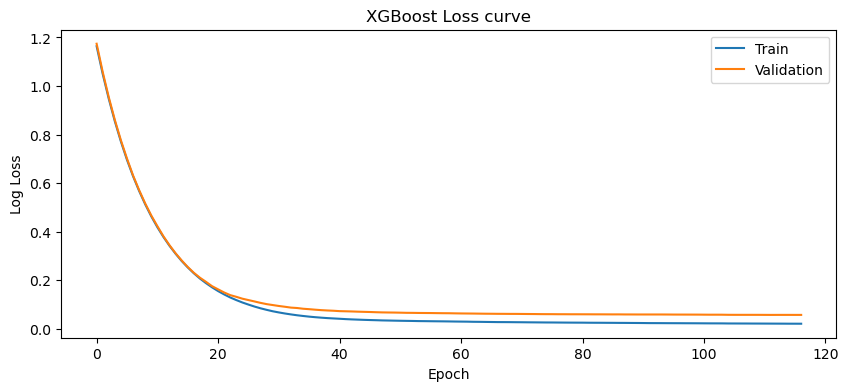

Training score:  0.994702280973843
Validation score:  0.965002727147902


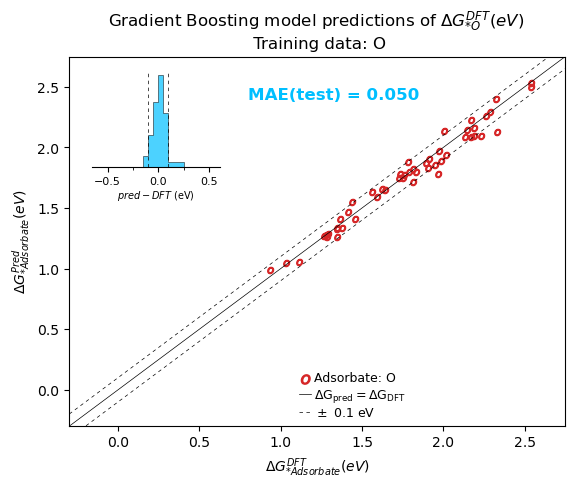

In [142]:
# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_O =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_O.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Save model in the /models folder
XGBModel_O.save_model("../models/"+"O.model")

learning_curve(XGBModel_O)

score = XGBModel_O.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_O.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

single_parity_plot(XGBModel_O, X_test, y_test, "O", "O") ## Maybe I should make a new line with MAE_avg
#single_parity_plot(XGBModel_H_Pro, X_test, y_test, "H", "H")

In [143]:
# Note: Maybe I should show an average MAE over 10 shuffles of the dataset? Not that important to the main aim of the project though. 

## Mix model: *COOH + *H

Feature vector: [H_feature0, H_feature1, ..., COOH_feature0, COOH_feature1]

In [144]:
# Loading two different .csv files, combining them properly and training a model on them. 

In [152]:
feature_folder = "../csv_features/"
filename_H = "COOH_H_Hvec_features.csv"
filename_COOH = "COOH_H_COOHvec_features.csv"

# Read the dataframes
H_df = pd.read_csv(feature_folder + filename_H)
COOH_df = pd.read_csv(feature_folder + filename_COOH)

# Combine the dataframes
combined_df = pd.merge(H_df, COOH_df, on="COOH_H_adsorbed_all_sites_out.dbrow")
y = combined_df[["G_ads (eV)"]] #Do I need to hardcopy this in order to not pass by reference?

# List of unwanted column names
unwanted_columns = ['G_ads(eV)', 'slab db row_x', 'COOH_H_adsorbed_all_sites_out.dbrow', 'G_ads (eV)', 'slab db row_y']

# Remove the unwanted columns from the combined dataframe
X = combined_df.drop(columns=unwanted_columns)

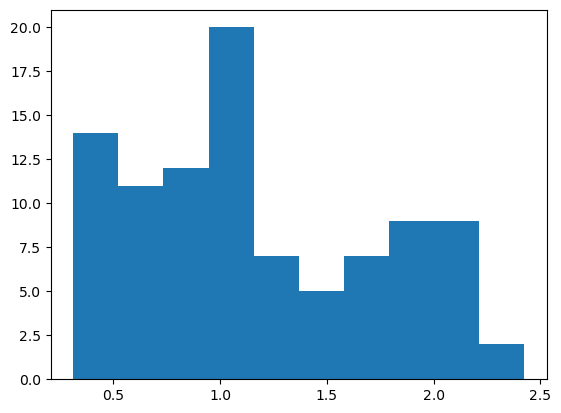

In [155]:
plt.hist(y)
plt.show()

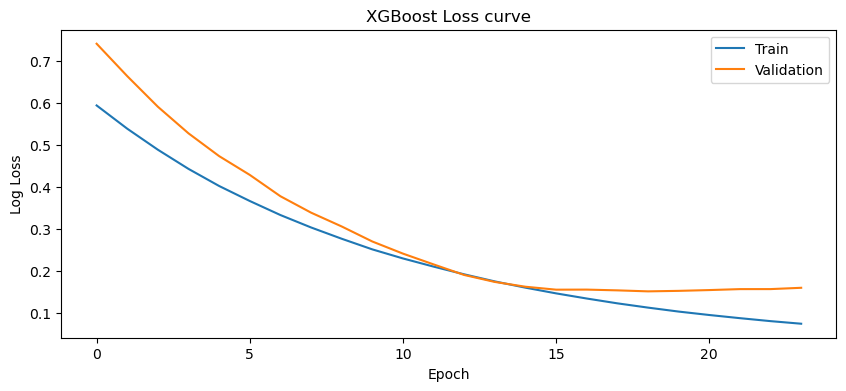

Training score:  0.9195230074581362
Validation score:  0.8031822055037112


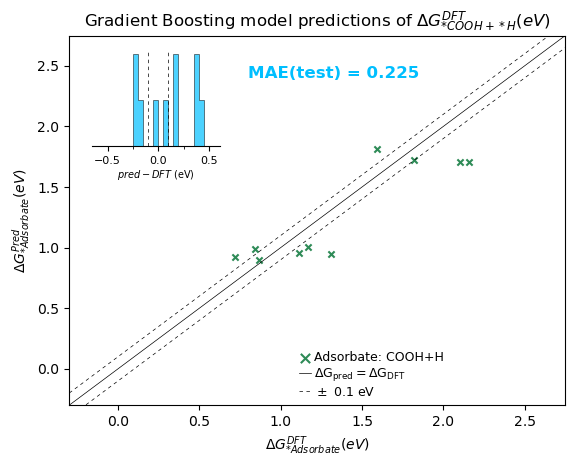

In [123]:
# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_COOH_H =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_COOH_H.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Save model in the /models folder
XGBModel_COOH_H.save_model("../models/"+"COOH_H.model")

learning_curve(XGBModel_COOH_H)

score = XGBModel_COOH_H.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_COOH_H.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

single_parity_plot(XGBModel_COOH_H, X_test, y_test, "COOH+H", "COOH+H") ## Maybe I should make a new line with MAE_avg
#single_parity_plot(XGBModel_H_Pro, X_test, y_test, "H", "H")

In [117]:
# Meeting early wednesday